<a href="https://colab.research.google.com/github/alighieris/TCC_ANN_syngas/blob/main/TCC_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas, configurações de ambiente e importação de dataset

In [ ]:
# Instalar Módulo Keras Tuner
%%capture
!pip install keras_tuner

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

from json import dumps

# Configurar ambiente

plt.style.use('default')
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 2
rc('font',family="Arial")
# Import dataset

titulos={'Pch4':u'Pressão parcial de CH\u2084 (kPa)',
         'Pco2':u'Pressão parcial de CO\u2082 (kPa)',
         'T':'Temperatura (°C)',
         'ch4/co2':u'Razão de alimentação (CH\u2084/CO\u2082)',
         'rh2':u'Taxa de reação de H\u2082 (mmol.min\u207B¹.g\u207B¹)',
         'rco':u'Taxa de produção de CO (mmol.min\u207B¹.g\u207B¹)',
         'ch4_conv':u'Conversão de CH\u2084 (%)',
         'co2_conv':u'Conversão de CO\u2082 (%)'}

## Configuração para uso do Google Colab + Google Drive

Configuração utilizada com o drive pessoal para armazenar dados e modelos.
Remover comentários para executar

In [ ]:

#from google.colab import drive
#drive.mount('/content/gdrive') # Configuração para salvar no Google Drive utilizando Google Colab
#df = pd.read_csv('/content/gdrive/MyDrive/TCC/database_ayodele.csv', sep=";", header=[0])

## Configuração Geral + GitHub

Configuração utilizada para acessar os scripts de maneira geral. Os dados e modelos são acessados através do GitHub.
Nessa configuração não é possível salvar os modelos diretamente, pois o salvamento é feito a partir do Google Drive.

In [90]:
%%capture
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/alighieris/TCC_ANN_syngas/main/database_ayodele.csv', sep=";", header=[0])

# Baixar modelos 
!pip install gitdir
url = 'https://github.com/alighieris/TCC_ANN_syngas/tree/main/models'
!gitdir {url}

# Análise e tratamento dos dados

### Análise exploratória 

In [10]:
pd.options.display.float_format = '{:,.2f}'.format
df.rename(columns=titulos).describe()

,Pressão parcial de CH₄ (kPa),Pressão parcial de CO₂ (kPa),Razão de alimentação (CH₄/CO₂),Temperatura (°C),Taxa de reação de H₂ (mmol.min⁻¹.g⁻¹),Taxa de produção de CO (mmol.min⁻¹.g⁻¹),Conversão de CH₄ (%),Conversão de CO₂ (%)
count,57.00,57.00,57.00,57.00,57.00,57.00,57.00,57.00
mean,38.16,38.16,1.63,700.88,3.70,5.12,52.61,64.06
std,15.46,15.46,2.36,41.72,2.31,2.04,14.82,18.16
min,5.00,5.00,0.05,650.00,0.15,1.20,23.15,17.86
25%,25.00,25.00,0.25,650.00,2.24,3.52,40.23,53.29
50%,50.00,50.00,0.50,700.00,3.13,5.35,52.85,68.31
75%,50.00,50.00,2.00,750.00,4.91,6.76,65.92,76.40
max,50.00,50.00,10.00,750.00,10.09,8.38,79.46,90.68


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pch4      57 non-null     int64  
 1   Pco2      57 non-null     int64  
 2   ch4/co2   57 non-null     float64
 3   T         57 non-null     int64  
 4   rh2       57 non-null     float64
 5   rco       57 non-null     float64
 6   ch4_conv  57 non-null     float64
 7   co2_conv  57 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 3.7 KB


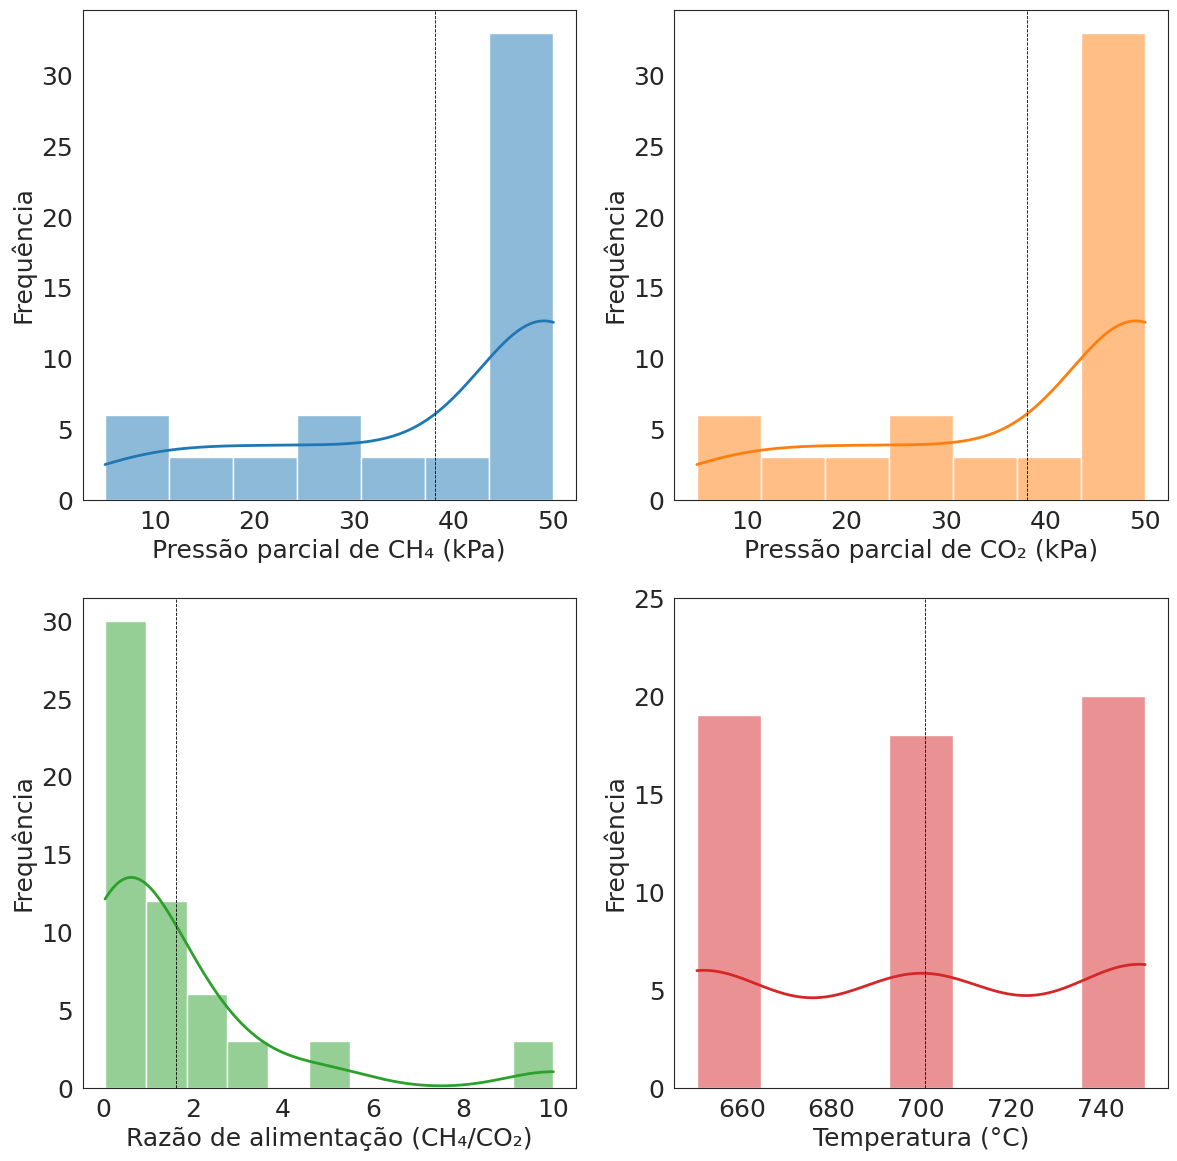

In [12]:
sns.set_style("white")
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 2
fig, axes = plt.subplots(2,2,figsize=(14,14))
for i in range(0,4):
  if i==3:
    plt.sca(ax=sum(axes.tolist(),[])[i])
    sns.histplot(df[df.columns[i]], kde=True,color="C"+str(i)).set_ylim([0,25])
    plt.axvline(df[df.columns[i]].mean(),linestyle="dashed", color ="k", linewidth=0.6)
    plt.xlabel(titulos[df.columns[i]])
    plt.ylabel("Frequência")
    
    continue
  plt.sca(ax=sum(axes.tolist(),[])[i])
  sns.histplot(df[df.columns[i]], kde=True,color="C"+str(i))
  plt.axvline(df[df.columns[i]].mean(),linestyle="dashed", color ="k", linewidth=0.6,)
  plt.xlabel(titulos[df.columns[i]])
  plt.ylabel("Frequência")

[Text(0, 0.5, 'X1'),
 Text(0, 1.5, 'X2'),
 Text(0, 2.5, 'X3'),
 Text(0, 3.5, 'X4')]

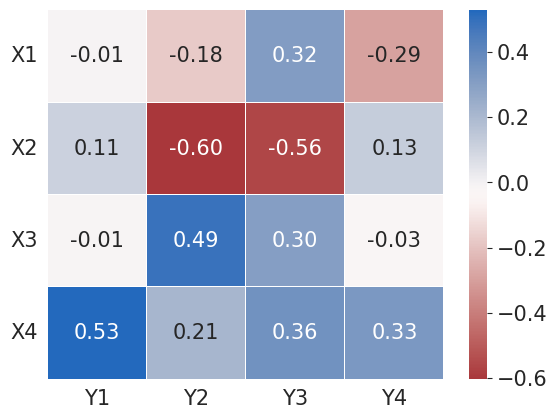

In [13]:
plt.rcParams['font.size'] = '15'
titulos2 = {'Pch4':'X1',
         'Pco2':'X2',
         'T':'X4',
         'ch4/co2':'X3',
         'rh2':'Y1',
         'rco':'Y2',
         'ch4_conv':'Y3',
         'co2_conv':'Y4'}
corr = df.rename(columns=titulos2).corr()
h = sns.heatmap(corr.iloc[:4,4:], annot = True, fmt='.2f', linewidths=.05, cmap="vlag_r");
h.set_yticklabels(h.get_yticklabels(), rotation=0, horizontalalignment='right')


Text(0, 0.5, 'Taxa de reação de H₂ (mmol.min⁻¹.g⁻¹)')

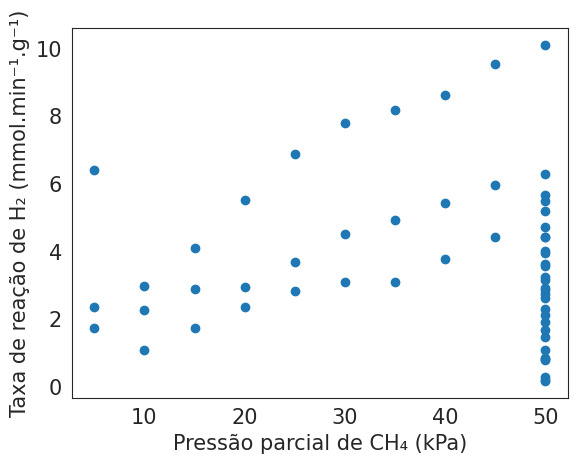

In [15]:
plt.scatter(df['Pch4'],df['rh2'])
plt.xlabel(titulos['Pch4'])
plt.ylabel(titulos['rh2'])

### Normalização de dados

In [91]:
# Normalização dos dados
scaler = MinMaxScaler()
norm_df = df.copy(deep=True)
norm_df.iloc[:,:4] = scaler.fit_transform(df.iloc[:,:4])
ntrain, ntest, train_labels, test_labels = train_test_split(norm_df.iloc[:,:4],norm_df.iloc[:,4:], test_size=0.2, random_state=4)

In [22]:
ntrain.describe()

,Pch4,Pco2,ch4/co2,T
count,45.00,45.00,45.00,45.00
mean,0.73,0.77,0.16,0.53
std,0.35,0.33,0.26,0.43
min,0.00,0.00,0.00,0.00
25%,0.44,0.56,0.02,0.00
50%,1.00,1.00,0.05,0.50
75%,1.00,1.00,0.16,1.00
max,1.00,1.00,1.00,1.00


In [23]:
ntest.describe()

,Pch4,Pco2,ch4/co2,T
count,12.00,12.00,12.00,12.00
mean,0.78,0.62,0.17,0.42
std,0.34,0.37,0.16,0.36
min,0.00,0.11,0.00,0.00
25%,0.69,0.31,0.03,0.00
50%,1.00,0.61,0.16,0.50
75%,1.00,1.00,0.27,0.50
max,1.00,1.00,0.50,1.00


In [24]:
ntrain.join(train_labels).describe()

,Pch4,Pco2,ch4/co2,T,rh2,rco,ch4_conv,co2_conv
count,45.00,45.00,45.00,45.00,45.00,45.00,45.00,45.00
mean,0.73,0.77,0.16,0.53,3.72,5.02,52.34,63.90
std,0.35,0.33,0.26,0.43,2.41,2.12,15.46,18.61
min,0.00,0.00,0.00,0.00,0.15,1.20,23.15,17.86
25%,0.44,0.56,0.02,0.00,1.88,3.52,40.23,56.14
50%,1.00,1.00,0.05,0.50,3.09,5.33,52.85,68.45
75%,1.00,1.00,0.16,1.00,5.17,6.76,66.95,76.40
max,1.00,1.00,1.00,1.00,10.09,8.38,79.46,90.68


In [25]:
ntest.join(test_labels).describe()

,Pch4,Pco2,ch4/co2,T,rh2,rco,ch4_conv,co2_conv
count,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
mean,0.78,0.62,0.17,0.42,3.63,5.46,53.65,64.63
std,0.34,0.37,0.16,0.36,1.99,1.75,12.65,17.10
min,0.00,0.11,0.00,0.00,0.81,2.27,35.70,34.13
25%,0.69,0.31,0.03,0.00,2.34,4.71,45.92,52.80
50%,1.00,0.61,0.16,0.50,3.38,5.76,51.45,62.50
75%,1.00,1.00,0.27,0.50,4.11,6.65,63.86,77.16
max,1.00,1.00,0.50,1.00,8.62,7.89,74.80,90.29


# ANN

## Define funções auxiliares

In [102]:
# Definir funções auxiliares

# Callback auxiliar para mostrar andamento do treinamento
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('.',end='')

# Callback auxiliar para Early Stop no treinamento
earlyStop=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=80,
    verbose=1,
)

def plot_regress(x,y):
  '''
  Retorna a curva de ajuste linear e retorna a equação do ajuste e o R².
    x: array
      Array contendo valores do eixo x
    y: array
      Array contendo valores do eixo y (deve ter mesmo tamanho do eixo x)
  '''
  slope, intercept, r_value, p_value, std_err = linregress(x,y)
  line = slope*x+intercept
  text = 'y={:.2f}x+{:.2f}    R2={:.2f}    std_err={:.2f}'.format(slope,intercept,r_value**2,std_err)
  print(text)
  return plt.plot(x, line, color='C0', linewidth=1), text

def custom_train(model,epochs,target_output,loss,split=0.1):
  '''
  Re-treinar modelo pós seleção de tunning
  ------------------------------------------------------------------------------
  O modelo será treinado novamente em condições customizadas e será avaliado com o conjunto de teste
    model : modelo Keras
        O melhor modelo tunado pelo Keras Tuner
    epochs : int
        O número de gerações em que o modelo vai ser treinado para avaliação.
    split : float
        A taxa que será separada para validação do modelo durante o treino. Caso não seja especificado 10% do conjunto de teste será usado para validação
    target_output : string
        O nome da variável objetivo
  '''

  history = model.fit(ntrain, train_labels[target_output], epochs=epochs, 
                      validation_split = split, batch_size=BATCH_SIZE, shuffle=True, 
                      callbacks=[PrintDot()]+CALLBACKS,verbose=0)
  data_hist = pd.DataFrame(history.history)
  data_hist['epoch'] = history.epoch

  fig = plt.figure(figsize=(14,13))

  ax1 = fig.add_subplot(221)
  plt.sca(ax1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss Error')
  plt.plot(data_hist['epoch'], data_hist['val_loss'],
           label = 'Val Error')
  plt.plot(data_hist['epoch'], data_hist['loss'],
           label='Train Error')
  plt.legend()
  ax2 = fig.add_subplot(222)
  plt.sca(ax2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MAE]')
  plt.plot(data_hist['epoch'], data_hist['val_mae'],
           label = 'Val Error')
  plt.plot(data_hist['epoch'], data_hist['mae'],
           label='Train Error')
  plt.legend()
  if loss=='huber':
    ax3 = fig.add_subplot(223)
    plt.sca(ax3)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [MSE]')
    plt.plot(data_hist['epoch'], data_hist['val_mse'],
           label = 'Val Error')
    plt.plot(data_hist['epoch'], data_hist['mse'],
           label='Train Error')
    plt.legend()
  plt.show()
  eval = model.evaluate(ntest,test_labels[target_output])
  text = (f'loss_method: {model.loss}    loss: {eval[0]}    mse: {eval[1]}    mae:{eval[2]}')
  return model, fig, text

def avg_rel_error(pred,actual):
  '''
    Cálculo do erro relativo médio entre valores preditos e valores reais.
    ----------------------------------------------------------------------------
    pred: array
      Valores preditos pelo modelo.
    actual: array
      Valores reais do output.
  '''
  somatorio = ((actual-pred.flatten())/actual).abs().sum()
  return (somatorio/len(pred))*100

def evaluate(model,target_output):
  '''
  Avaliar modelo e plotar gráficos
  ------------------------------------------------------------------------------
  Fará predição dos dados e plot de gráficos e ajuste de curvas para comparação de desempenho.
    model : modelo Keras
        O melhor modelo treinado
    target_output : string
        O nome da variável objetivo
  '''
  predict = model.predict(ntest)
  max = round(predict.max())
  min = round(predict.min())
  max = round(max+(max-min)*0.2)
  min = round(min-(max-min)*0.2)
  if min<0:min=0
  fig = plt.figure(figsize=(7,6))
  plt.scatter(predict,test_labels[target_output], color="C0")

  plt.plot(range(min,max+1),range(min,max+1), color="k", linewidth=0.3)
  ax, text = plot_regress(predict.flatten(),test_labels[target_output])
  plt.xlabel('Predição')
  plt.ylabel('Experimental')
  plt.xlim(min,max)
  plt.ylim(min,max)

  plt.title(f'{titulos[target_output]}')
  plt.show()
  text += "\nMAE_teste: {:.4f}    MSE_teste: {:.4f}     MAPE:{:4f}".format(mean_absolute_error(predict,test_labels[target_output])
                                                            ,mean_squared_error(predict,test_labels[target_output]),
                                                            avg_rel_error(predict,test_labels[target_output]))

  return predict, fig, text

def choose_target():
  '''
    Definir variável objetivo no treinamento.
  '''
  while True:
    target = input('Escolher variável objetivo: \n-> rh2 = Taxa de produção de H2 \n-> rco = Taxa de produção de CO\n-> ch4_conv = Conversão de CH4 \n-> co2_conv = Conversão de CO2\n')
    if target in ['rh2','rco', 'ch4_conv', 'co2_conv']:
      break
    print('Escolha uma das opções indicadas.')
  return target

## Definir construtor de modelo e Tuning

In [103]:
# PARÂMETROS GLOBAIS

PATIENCE = 80
CALLBACKS = []
BATCH_SIZE = 10


In [104]:
def model_builder(hp):
  '''
    Construir modelo geral para HPO
    ----------------------------------------------------------------------------
    Define a estrutura global da rede neural para passar pela otimização de hiperparâmetros. Recebe apenas 'hp', 
    que são as variações de hiperparâmetros inputadas pelo otimizador. 
  '''
  
  model = keras.Sequential()

  # Definir quantidade de camadas e número de neurônios em cada camada
    # Define camada de inputs (4 nós) + primeira camada oculta
  model.add(keras.layers.Dense(units=hp.Int('first_layer', min_value=6, max_value=40, step=1), activation='relu', input_dim=4))
    # Define número de camadas ocultas e quantidade de neurônios em cada uma
  for i in range(hp.Int('n_layers', min_value=0, max_value=2, step=1)):
    model.add(keras.layers.Dense(units=hp.Int(f'units_in_layer_{i+1}',min_value=6, max_value=30, step=1), activation='relu'))
    # Define camada de saída, com único nó e tipo de ativação linear para obter valores reais
  model.add(keras.layers.Dense(1, activation='linear'))

  #Tunar a taxa de aprendizado do modelo para o otimizador Adam.
  hp_learning_rate = hp.Choice('learning_rate', values=[1.0,0.1, 0.08,0.06,0.04,0.02,0.01,0.005,0.001,0.0005])

  # Compilar modelo e decidir qual método de "loss" será usado.
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=hp.Choice('loss_method', values=['huber', 'mse', 'mae']),
                metrics=['mse','mae'])

  return model

target_output = choose_target()

# Definir o objeto de tuning que fará a otimização dos HP
tuner = kt.RandomSearch(model_builder,
                        objective='val_loss',
                        max_trials=50,
                        executions_per_trial=1,
                        overwrite=True
                        )
tuner.search(x=ntrain,
             y=train_labels[target_output],
             epochs=120,
             batch_size=BATCH_SIZE,
             validation_data=(ntest,test_labels[target_output]),
             callbacks=CALLBACKS
             )

Trial 1 Complete [00h 00m 07s]
val_loss: 0.1387552171945572

Best val_loss So Far: 0.1387552171945572
Total elapsed time: 00h 00m 07s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
22                |28                |first_layer
1                 |1                 |n_layers
0.01              |0.04              |learning_rate
huber             |mse               |loss_method
21                |6                 |units_in_layer_1

Epoch 1/120
5/5 [==============================] - 1s 54ms/step - loss: 3.1588 - mse: 18.9805 - mae: 3.6390 - val_loss: 2.2951 - val_mse: 10.8631 - val_mae: 2.7715
Epoch 2/120
5/5 [==============================] - 0s 11ms/step - loss: 2.0889 - mse: 11.0714 - mae: 2.5517 - val_loss: 1.0660 - val_mse: 4.2215 - val_mae: 1.4938
Epoch 3/120
5/5 [==============================] - 0s 12ms/step - loss: 1.3022 - mse: 5.3511 - mae: 1.7192 - val_loss: 0.8857 - val_mse: 3.0871 - val_mae: 1.3491
Epoch 4/120
5/5 [=========================

KeyboardInterrupt: ignored

{'first_layer': 28, 'n_layers': 1, 'learning_rate': 0.04, 'loss_method': 'mse', 'units_in_layer_1': 6}
......

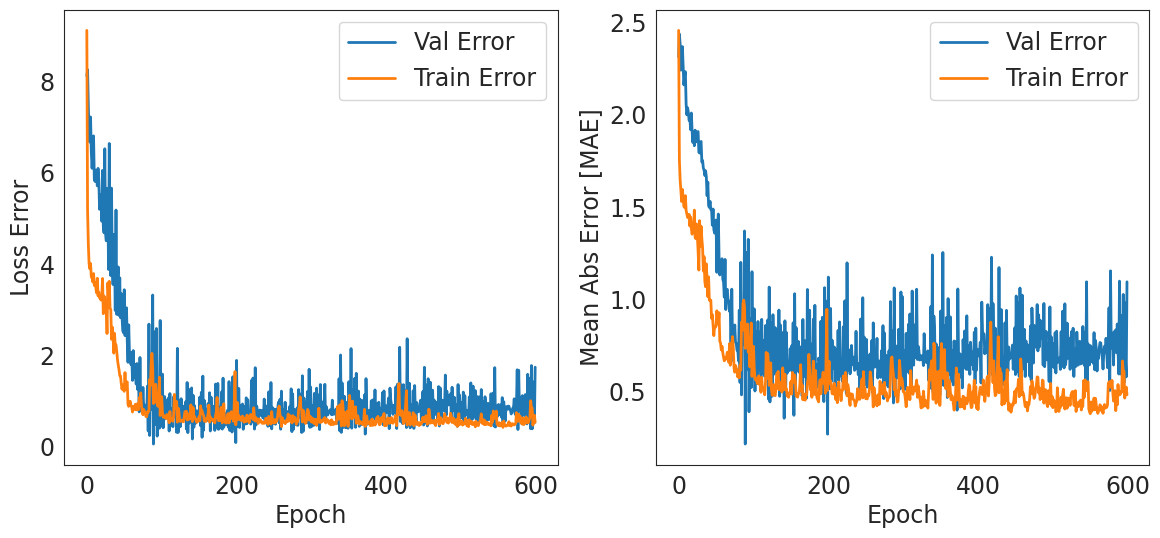

1/1 [==============================] - 0s 44ms/step
y=1.10x+0.49    R2=0.97    std_err=0.07


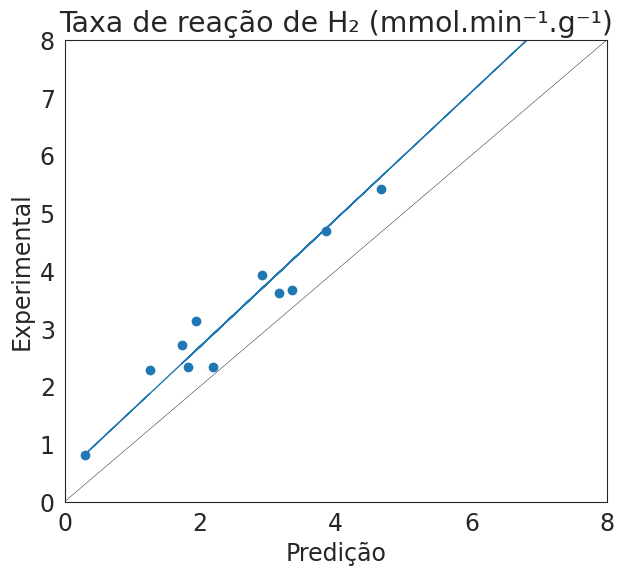

In [105]:
# Obtém as conifg. da melhor rede tunada e cria um modelo para treinamento final
best_tune=tuner.get_best_hyperparameters()[0]
print(best_tune.get_config()['values'])
loss = best_tune.get_config()['values']['loss_method']
# Constrói novo modelo baseado nos HP otimizados
tuned_model = tuner.hypermodel.build(best_tune)
# Treina o novo modelo -> Retorna curvas de erro no treinamento e validação
tuned_model, fig_loss, text_loss = custom_train(tuned_model,600,target_output,loss)
# Gera a avaliação do modelo -> Retorna gráfico Q-Q
pred, fig_compare, text_compare = evaluate(tuned_model,target_output)

## Salvar modelo

Só funciona ao usar o drive. Pode precisar de mudanças nas configurações.

In [ ]:
nome = input('Nome do modelo:')
tuned_model.save('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome)
fig_loss.savefig('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/Loss.png',format='png',bbox_inches='tight')
fig_compare.savefig('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/Compare.png',format='png',bbox_inches='tight')
f = open('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/dados.txt','w')
f.write(text_loss+"\n---------\n"+text_compare+"\n---------\n"+dumps(tuned_model.get_config(),indent=4))
f.close()

Nome do modelo:rco_ok3


## Carregar modelos

In [ ]:
# Carregar modelos do drive
model_name = str(input('Nome do Modelo:'))
model_load = keras.models.load_model('/content/gdrive/MyDrive/TCC/Models/ayodele/'+model_name)

In [106]:
# Carregar modelos do Github
model_name = str(input('Nome do Modelo (nome da pasta):'))
model_load = keras.models.load_model('./models/'+model_name)

Nome do Modelo (nome da pasta):xrco


Escolher variável objetivo: 
-> rh2 = Taxa de produção de H2 
-> rco = Taxa de produção de CO
-> ch4_conv = Conversão de CH4 
-> co2_conv = Conversão de CO2
rco
1/1 [==============================] - 0s 46ms/step
y=1.02x+-0.07    R2=0.97    std_err=0.05


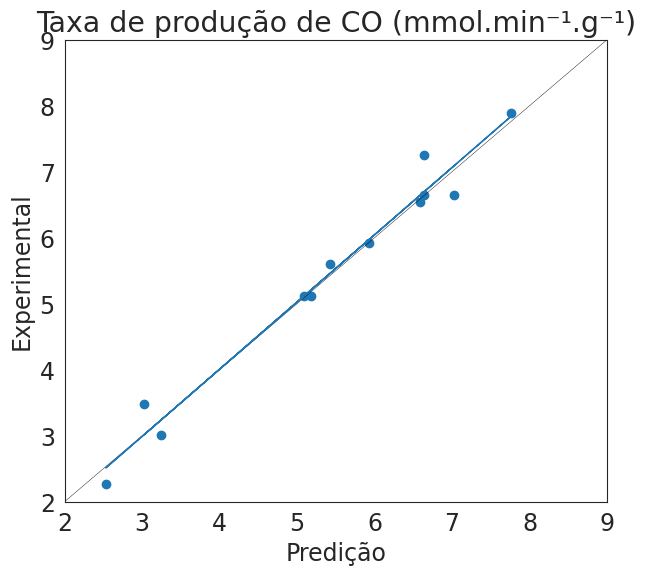

In [107]:
# Gerar previsão
target_output = choose_target()
plt.rcParams['font.size'] = '17'
pred, fig_compare, text_compare = evaluate(model_load, target_output)

### Previsão dos resultados

In [110]:
#Prever resultados
'''
Pch4 = input("Pressão parcial de CH4: ") 
Pco2 = input("Pressão parcial de CO2: ") 
T = input("Temperatura de operação (de 650 a 750 °C): ") 
feed_ratio = input("Fração de alimentação (CH4/CO2): ")'''
Pch4 = 45 #@param {type:"number"}
Pco2 = 55 #@param {type:"number"}
feed_ratio =  1.5#@param {type:"number"}
T = 750 #@param {type:"number"}
df_pred = pd.DataFrame([[Pch4,Pco2,feed_ratio,T]],columns = ['Pch4','Pco2','ch4/co2','T'])
print(f'O valor previsto é:\n{titulos[target_output]} = {model_load.predict(scaler.transform(df_pred))[0][0]:.4f}')

1/1 [==============================] - 0s 17ms/step
O valor previsto é:
Taxa de produção de CO (mmol.min⁻¹.g⁻¹) = 2.4181


# Pycaret

In [ ]:
# Istalação do Módulo
!pip install pycaret
from pycaret.regression import *


In [ ]:
#Configuração do setup (costrução base para o treinamento, carregando os dados e opções do framewokr)
target_output = choose_target()
ignored = ['rh2', 'rco', 'ch4_conv', 'co2_conv']
ignored.remove(target_output)
df_pycaret = ntrain.join(train_labels[target_output])
stp = setup(df_pycaret, target=target_output,
            normalize=False, session_id=2022)

## Treinar e modelos e otimizar o melhor


In [ ]:

best = compare_models(include=['svm', 'lr', 'rf', 'gbr', 'lasso', 'dt'])
tuned = create_model(best)
tuned = tune_model(tuned)
model_info = str(tuned)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.1045,132.0863,11.4929,-3.5189,0.1598,0.1035
1,19.1604,506.2733,22.5005,0.4531,0.6248,0.7560
2,7.8957,63.1358,7.9458,-2.0572,0.1123,0.1102
3,5.8347,49.3175,7.0226,-0.2439,0.1015,0.0884
4,11.0034,159.9626,12.6476,-0.0939,0.1693,0.1424
5,5.4205,51.9570,7.2081,0.8543,0.0914,0.0738
6,10.9921,175.8722,13.2617,-0.8176,0.2310,0.2232
7,5.7738,40.4623,6.3610,0.6966,0.1162,0.1065
8,6.6759,62.9089,7.9315,0.5916,0.1161,0.1001


INFO:logs:create_model_container: 8
INFO:logs:master_model_container: 8
INFO:logs:display_container: 4
INFO:logs:RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=11, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.005,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=-1, oob_score=False,
                      random_state=2022, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


## Avaliar modelo


y=1.48x+-31.10    R2=0.88    std_err=0.17


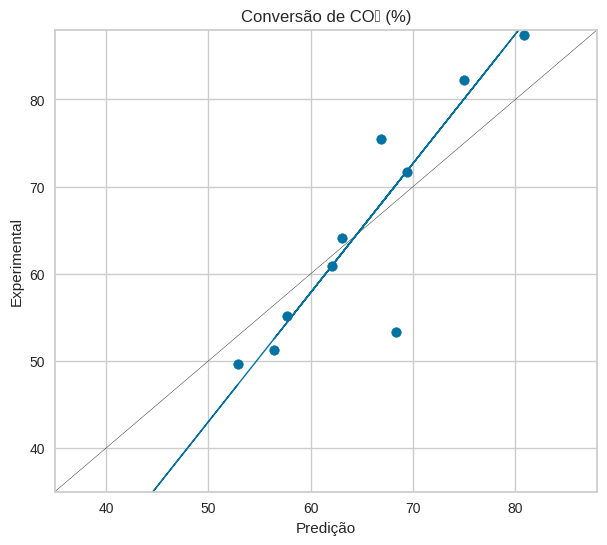

y=1.48x+-31.10    R2=0.88    std_err=0.17
MAE_teste: 6.2050    MSE_teste: 56.8718     MAPE:10.464396


In [ ]:
pred, fig_compare, text_compare = evaluate(tuned, target_output)
print(text_compare)

## Salvar modelo

Só funciona usando Colab + Google Drive

In [ ]:
nome = input('Nome do modelo:')
!mkdir '/content/gdrive/MyDrive/TCC/Models/ayodele/'$nome
save_model(tuned,'/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/'+nome)
#fig_loss.savefig('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/Loss.png',format='png',bbox_inches='tight')
fig_compare.savefig('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/Compare.png',format='png',bbox_inches='tight')
f = open('/content/gdrive/MyDrive/TCC/Models/ayodele/'+nome+'/dados.txt','w')
f.write(text_compare+"\n---------\n"+model_info)
f.close()